<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

#### Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model

In [ ]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv

### Import required packages

In [ ]:
!pip -qq install stellargraph

     |████████████████████████████████| 435 kB 8.0 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import stellargraph as sg
from stellargraph.layer import GCN
import networkx as nx
from datetime import datetime
import seaborn as sns

### Data loading and preparation ( 2 points)

In [ ]:
adj_path = "/content/los_adj.csv"
speed_data_path= "/content/los_speed.csv"

In [ ]:
# YOUR CODE HERE
los_adj_df = pd.read_csv(adj_path)
speed_data_path_df = pd.read_csv(speed_data_path)

print(los_adj_df.head())
print(speed_data_path_df.head())

     1         0       0.1       0.2  ...  0.184  0.185  0.186  0.187
0  0.0  1.000000  0.717438  0.000000  ...    0.0    0.0    0.0    0.0
1  0.0  0.717438  1.000000  0.000000  ...    0.0    0.0    0.0    0.0
2  0.0  0.000000  0.000000  1.000000  ...    0.0    0.0    0.0    0.0
3  0.0  0.000000  0.000000  0.633722  ...    0.0    0.0    0.0    0.0
4  0.0  0.000000  0.000000  0.894812  ...    0.0    0.0    0.0    0.0

[5 rows x 207 columns]
      773869     767541     767542  ...     772168     718141     769373
0  64.375000  67.625000  67.125000  ...  59.250000  69.000000  61.875000
1  62.666667  68.555556  65.444444  ...  55.888889  68.444444  62.875000
2  64.000000  63.750000  60.000000  ...  61.375000  69.857143  62.000000
3  61.777778  65.500000  62.555556  ...  60.138889  69.571429  60.444444
4  59.555556  67.250000  65.111111  ...  58.902778  69.285714  58.888889

[5 rows x 207 columns]


In [ ]:
speed_data_path_df.shape

(2016, 207)

In [ ]:
los_adj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Columns: 207 entries, 0 to 206
dtypes: float64(206), int64(1)
memory usage: 334.9 KB


In [ ]:
los_adj_df.columns

Index(['1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       ...
       '0.179', '0.180', '0.119804092', '0.181', '0.182', '0.183', '0.184',
       '0.185', '0.186', '0.187'],
      dtype='object', length=207)

In [ ]:
speed_data_path_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 3.2 MB


#### Plotting the time series of 10 sensors data

In [ ]:
time_df = pd.date_range(start="2012-03-01",end="2012-03-07", periods = 2016).to_pydatetime()
speed_data_path_df["DateTime"] = time_df.tolist()

In [ ]:
speed_data_path_df.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373,DateTime
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.75,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125000,66.875000,64.000000,62.000000,64.375000,60.750000,60.750,62.375000,...,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875000,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000,2012-03-01 00:00:00.000000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.00,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000000,67.444444,66.444444,67.222222,63.000000,64.333333,64.000,61.888889,...,66.555556,67.333333,55.333333,66.555556,66.555556,65.777778,59.888889,66.888889,67.444444,62.222222,62.222222,52.333333,47.666667,67.111111,64.500000,69.111111,63.888889,60.444444,65.777778,63.888889,69.333333,63.000000,67.666667,67.333333,66.666667,65.777778,51.666667,69.111111,39.888889,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000,2012-03-01 00:04:17.270471
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,61.375000,62.375000,64.750000,65.250000,61.875000,67.875000,35.25,63.875000,35.625000,65.000000,69.125000,49.125000,55.625000,59.125000,67.875000,63.125000,63.000000,64.500000,59.000000,47.750000,61.571429,66.500000,68.500000,65.000000,66.250000,51.250000,63.875000,64.875000,65.625,64.625000,...,67.375000,65.250000,58.125000,64.625000,67.375000,66.750000,56.000000,68.750000,65.625000,61.000000,63.500000,56.125000,61.375000,64.125000,66.000000,68.625000,67.250000,64.000000,66.875000,65.000000,65.500000,54.875000,68.750000,67.375000,65.750000,56.250000,49.375000,67.250000,38.250000,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000,2012-03-01 00:08:34.540942
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,62.138889,63.694444,64.055556,65.277778,60.472222,68.027778,39.50,64.250000,37.527778,65.666667,67.750000,50.305556,53.416667,60.638889,68.250000,64.083333,64.666667,64.111111,61.111111,49.944444,60.714286,66.777778,67.777778,65.222222,65.833333,53.388889,65.916667,65.583333,63.750,64.194444,...,65.583333,66.833333,58.083333,62.750000,66.027778,64.277778,58.333333,68.833333,64.194444,62.333333,62.666667,51.972222,62.916667,64.305556,64.000000,68.527778,65.944444,63.777778,66.583333,62.888889,66.777778,54.694444,67.722222,66.805556,65.944444,58.388889,51.138889,68.166667,37.833333,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444,2012-03-01 00:12:51.811414
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,62.902778,65.013889,63.361111,65.305556,59.069444,68.180556,43.75,6

(array([   0,    1,    2, ..., 2013, 2014, 2015]),
 <a list of 2016 Text major ticklabel objects>)

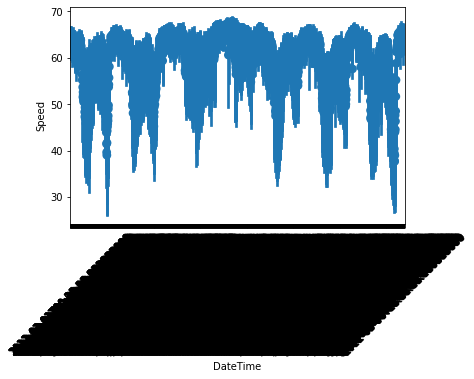

In [ ]:
#graph_data = los_speed.iloc[:, :10]
df = speed_data_path_df.iloc[:, :10].copy()
df['DateTime'] = speed_data_path_df["DateTime"]
df = df.melt('DateTime', var_name='cols',  value_name='Speed')
g = sns.pointplot(x="DateTime", y="Speed", data=df)
plt.xticks(rotation=45)

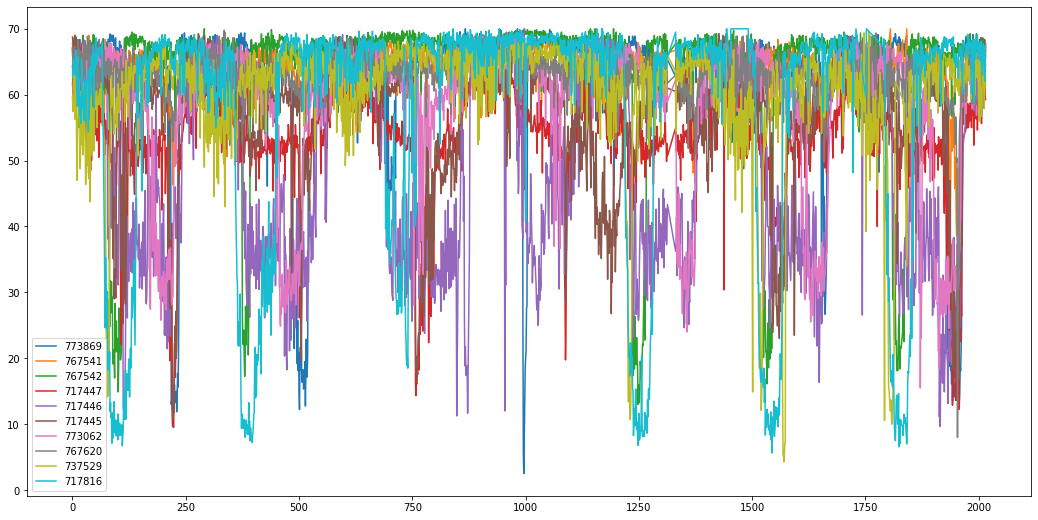

In [ ]:
df = speed_data_path_df.iloc[:, :10].copy()
#df['DateTime'] = speed_data_path_df["DateTime"]
# df = df.melt('DateTime', var_name='cols',  value_name='Speed')
df.plot(kind='line', figsize=(18,9))
#g = sns.pointplot(x="DateTime", y="Speed", data=df)
#plt.xticks(rotation=45)

In [ ]:
# df = speed_data_path_df[: 10].copy()
# df = df.melt('DateTime', var_name='cols',  value_name='Speed')
# g = sns.pointplot(x="DateTime", y="Speed", data=df)
# plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

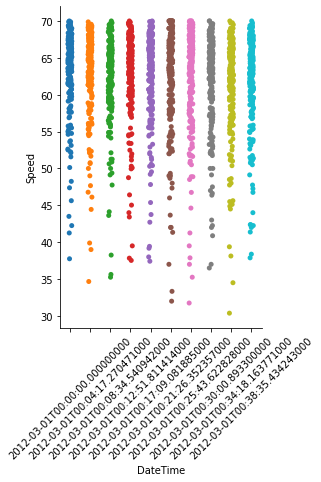

In [ ]:
g = sns.catplot(x="DateTime", y="Speed",data=df)
plt.xticks(rotation=45)

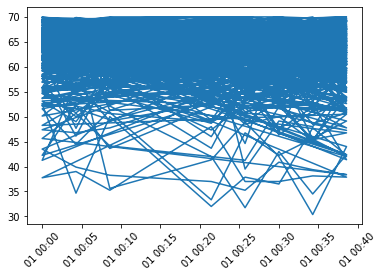

In [ ]:
# YOUR CODE HERE
plt.plot(df['DateTime'], df['Speed'], '-')
_ = plt.xticks(rotation=45)

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

In [ ]:
# YOUR CODE HERE
#df_los_adj = los_adj_df.melt(los_adj_df.index, var_name='cols',  value_name='adj')
network = nx.Graph()
network.add_nodes_from(los_adj_df.columns)
print(f"This network has now {network.number_of_nodes()} nodes.")



This network has now 207 nodes.


In [ ]:
#make a list of all nodes
import itertools

adjacent_columns = list(los_adj_df.columns)


los_adj_df_t = los_adj_df.T
list_of_overlaps = []
for node in adjacent_columns:
  #print(los_adj_df_t.loc[node])
  #print(node)
  #print(list(los_adj_df_t.loc[node].index))
  #break
  list_of_overlaps.append(list(los_adj_df_t.loc[node].index))
  #list_of_overlaps.append(list(without_subj.loc[without_subj[student]].index))

for sublist in list_of_overlaps:
   for pair in itertools.combinations(sublist, 2):
      network.add_edge(pair[0], pair[1])


In [ ]:
n_edges_total = len(list(network.edges))
print(n_edges_total)

21115


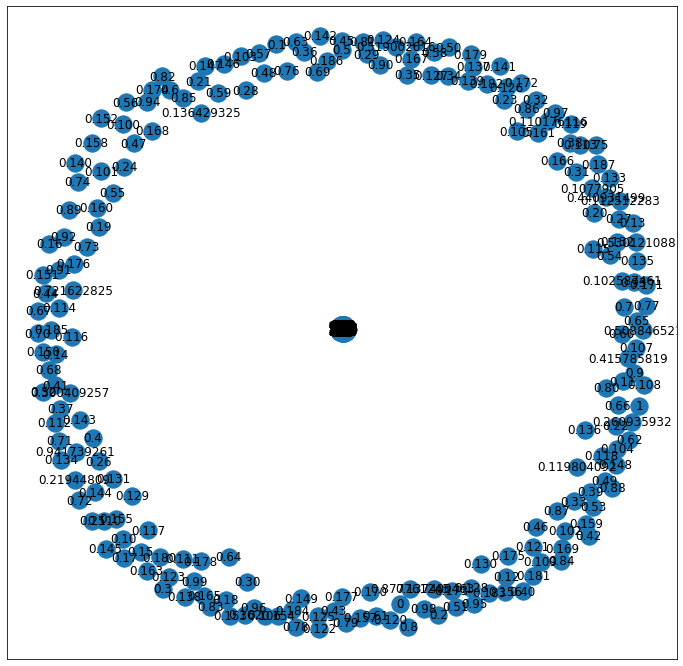

In [ ]:
fig = plt.figure(figsize=(12,12))
nx.draw_networkx(network, with_labels=True, arrows=True)

In [ ]:
max(dict(network.degree).values())

205

In [ ]:
# import random
# get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
# get_colors(205) # sample return:  ['#8af5da', '#fbc08c', '#b741d0', '#e599f1', '#bbcb59', '#a2a6c0']

#### Preprocessing and train test split

In [ ]:
# YOUR CODE HERE
los_adj_df = pd.read_csv(adj_path, header=None)
speed_data_path_df = pd.read_csv(speed_data_path)


print(los_adj_df.head())
print(speed_data_path_df.head())


# los_adj_mat = np.mat(los_adj_df)
# print(los_adj_mat)


# time_len = speed_data_path_df.shape[0]
# num_nodes = speed_data_path_df.shape[1]
# speed_data_path1 =np.mat(speed_data_path_df,dtype=np.float32)

   0         1         2         3         4    ...  202  203  204  205  206
0  1.0  0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
1  0.0  1.000000  0.717438  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
2  0.0  0.717438  1.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
3  0.0  0.000000  0.000000  1.000000  0.633722  ...  0.0  0.0  0.0  0.0  0.0
4  0.0  0.000000  0.000000  0.633722  1.000000  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 207 columns]
      773869     767541     767542  ...     772168     718141     769373
0  64.375000  67.625000  67.125000  ...  59.250000  69.000000  61.875000
1  62.666667  68.555556  65.444444  ...  55.888889  68.444444  62.875000
2  64.000000  63.750000  60.000000  ...  61.375000  69.857143  62.000000
3  61.777778  65.500000  62.555556  ...  60.138889  69.571429  60.444444
4  59.555556  67.250000  65.111111  ...  58.902778  69.285714  58.888889

[5 rows x 207 columns]


In [ ]:
print(los_adj_df.shape)
print(speed_data_path_df.shape)

(207, 207)
(2016, 207)


#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [ ]:
seq_len = 10
pre_len = 12
train_rate = 0.8

In [ ]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [ ]:
train_data, test_data = train_test_split(speed_data_path_df.T, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


In [ ]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [ ]:
train_scaled, test_scaled = scale_data(train_data, test_data)

In [ ]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        #print(a.shape)
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [ ]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


### Build and Train the LSTM model and plot the loss results (3 points)

In [ ]:
inputs = keras.layers.Input(shape=(trainX.shape[1], trainX.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 207, 10)]         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                5504      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_lstm = model.fit(
    trainX,
    trainY,
    epochs=10,
    validation_data=(testX, testY),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
 7/50 [===>..........................] - ETA: 0s - loss: 0.0263

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


50/50 [==============================] - 1s 24ms/step - loss: 0.0284 - val_loss: 0.0354

Epoch 00001: val_loss improved from inf to 0.03537, saving model to model_checkpoint.h5
Epoch 2/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0282 - val_loss: 0.0373

Epoch 00002: val_loss did not improve from 0.03537
Epoch 3/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0285 - val_loss: 0.0352

Epoch 00003: val_loss improved from 0.03537 to 0.03518, saving model to model_checkpoint.h5
Epoch 4/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0280 - val_loss: 0.0350

Epoch 00004: val_loss improved from 0.03518 to 0.03503, saving model to model_checkpoint.h5
Epoch 5/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0281 - val_loss: 0.0350

Epoch 00005: val_loss improved from 0.03503 to 0.03501, saving model to model_checkpoint.h5
Epoch 6/10
50/50 [==============================] - 1s 23ms/step - loss: 0.0279 - val_loss: 0.03

In [ ]:
history_lstm.history.keys()

dict_keys(['loss', 'val_loss'])

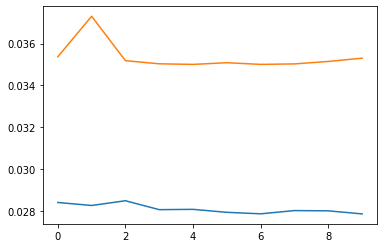

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])

In [ ]:
from stellargraph.layer import GCN_LSTM

gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=los_adj_df,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

x_input, x_output = gcn_lstm.in_out_tensors()

model = Model(inputs=x_input, outputs=x_output)

model.compile(optimizer="adam", loss="mae", metrics=["mse"])

history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=(testX, testY),
)

print(model.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  if __name__ == '__main__':


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 207, 10)]         0         
_________________________________________________________________
tf.expand_dims_6 (TFOpLambda (None, 207, 10, 1)        0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 207, 10)           0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 16)           43216     
_________________________________________________________________
fixed_adjacency_graph_convol (None, 207, 10)           43216     
_________________________________________________________________
reshape_19 (Reshape)         (None, 207, 10, 1)        0         
_________________________________________________________________
permute_6 (Permute)          (None, 10, 207, 1)        0   

In [ ]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

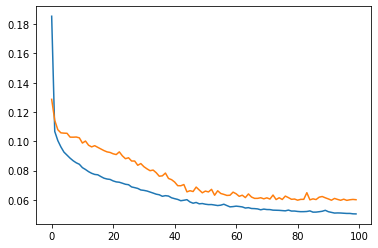

In [ ]:
# YOUR CODE HERE to plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

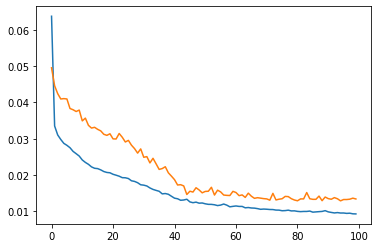

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [ ]:
from stellargraph.layer import GCN_LSTM

#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [ ]:
# YOUR CODE HERE

### Plot the predictions and Loss of each sensor ( 2 points)

* Select any one sensor's prediction and plot the graph.

In [ ]:
# YOUR CODE HERE

#### Plot error (MAE and MSE) for all the sensors

In [ ]:
# YOUR CODE HERE

#### Report Analysis

  * Discuss: Why is this called a spatio-temporal problem?

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?

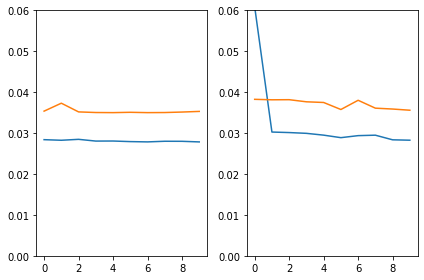

In [ ]:
plt.subplot(1, 2, 1)

plt.plot(history_lstm.history['loss'], )
plt.plot(history_lstm.history['val_loss'])
plt.ylim(ymin = 0, ymax = 0.06)
plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], )
plt.plot(history.history['val_loss'])

plt.ylim(ymin = 0, ymax = 0.06)

plt.tight_layout()